# Informe Final Carrera - Proyecto 04

## Pasos a seguir para realizar el proyecto 04.

### 1) Punto de partida : 

##### Proyecto 03 - Series de Tiempo

### 2) Formula una nueva pregunta, problema o desafío para explorar:  

##### Probar modelos de Machine Learning nuevos, no vistos en la carrera. 

El proyecto va a consistir en aplicar modelos de machine learning que específicamente se aplican para el análisis y predicción de series de tiempo según lo que he podido investigar y estudiar en modo complementario al curso actual. Tales casos son :

    *Redes Neuronales
    *ARIMA, SARIMA
    *Prophet

### 3) Objetivo: 

##### El objetivo es poder aplicar los modelos mencionados con sus características particulares y lograr visalizar una comparación de los resultados que arrojan los mismos, e identificar cuál es el que mejor se ajusta al problema de referencia. 

### 1) Punto de partida : Proyecto 03 - Series de Tiempo

#### Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

link de github 

Proyecto 3 - Series de Tiempo:

https://github.com/ManciniJulian8/ProyectosDataScience/blob/main/CertificaciondataScienceAcamica/Proyecto%203%20Series%20de%20Tiempo/DS_Proyecto_03_ST.ipynb

Proyecto 4 - Informe Final Carrera:
    


***Subíndice***   

1. [Preparación del Dataset](#id11)
2. [Resampleos](#id12)
3. [Outliers](#id13)
4. [Valores Faltantes](#id14)
5. [Año 2020](#id15)
6. [Train/Test Split](#id16)

#### Preparación del Dataset<a name="id11"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set()

In [2]:
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from prophet import Prophet
import warnings
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

C:\Users\julian.mancini\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
Importing plotly failed. Interactive plots will not work.


In [3]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [4]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [5]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [6]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [7]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


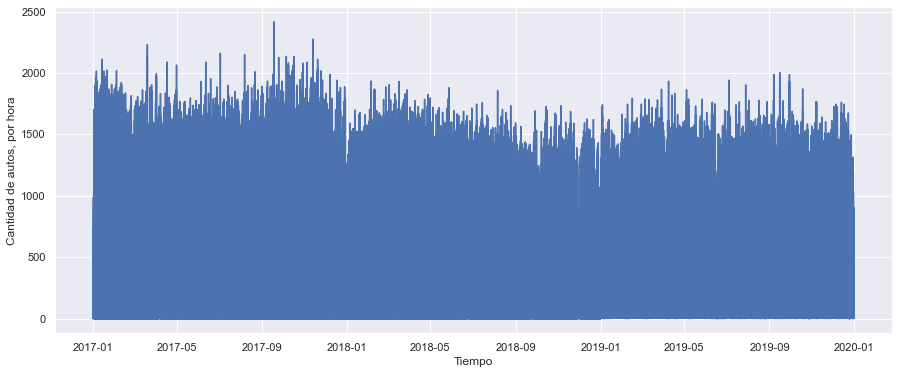

In [8]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

#### Resampleos<a name="id12"></a>

In [9]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


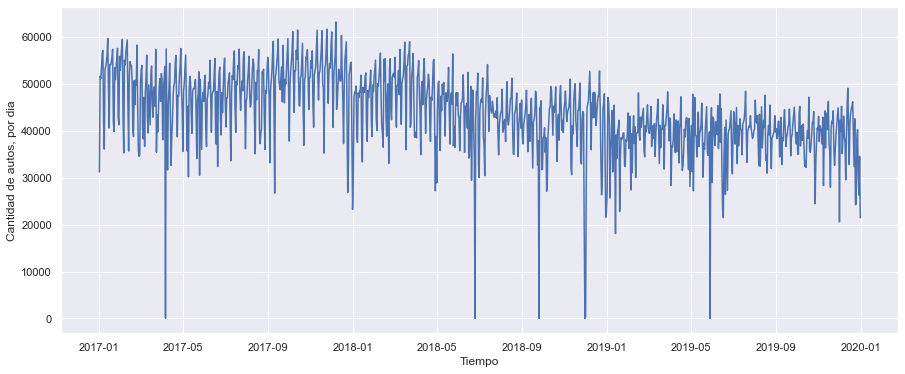

In [10]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [11]:
diario

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-12-27,40182
2019-12-28,30681
2019-12-29,26259


#### Voy a trabajar con la serie con frecuencia diaria, para poder tener más datos de entrenamiento

In [12]:
diario.shape
diario

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-12-27,40182
2019-12-28,30681
2019-12-29,26259


* Grafico a continuación para observar la distribución y posible detección de Outliers

<AxesSubplot:ylabel='cantidad_pasos'>

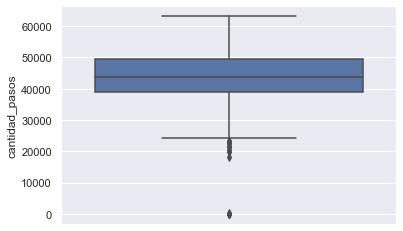

In [13]:
sns.boxplot(y=diario.cantidad_pasos)

##### Rango Intercuartílico<a name="id13"></a>

In [14]:
q25, q75 = np.percentile(diario.cantidad_pasos.values, [25,75])
iqr = q75 - q25
minimo = q25 - 1.5*iqr
maximo = q75 + 1.5*iqr
print(q25,q75,iqr, minimo, maximo)

39061.5 49498.0 10436.5 23406.75 65152.75


##### Deteccion de Outliers

In [15]:
diario_OUT = diario[(diario.cantidad_pasos < minimo) | (diario.cantidad_pasos > maximo)]
print(diario_OUT.shape)
print(diario_OUT)

(16, 1)
            cantidad_pasos
fecha                     
2017-04-06              40
2017-12-31           23229
2018-06-25               0
2018-09-25               0
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2018-12-30           21559
2018-12-31           22599
2019-01-13           18076
2019-01-19           22774
2019-05-29               0
2019-06-16           23190
2019-06-17           21469
2019-12-01           20553
2019-12-31           21447


##### Eliminación de Outliers

In [16]:
diario.cantidad_pasos[diario.cantidad_pasos < minimo] = np.nan
diario.cantidad_pasos[diario.cantidad_pasos > maximo] = np.nan
print(diario.shape)
print(diario)

(1095, 1)
            cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31             NaN

[1095 rows x 1 columns]


#### VALORES FALTANTES<a name="id14"></a>

In [17]:
print(diario.isna().sum())

cantidad_pasos    16
dtype: int64


In [18]:
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    0
dtype: int64


* Grafico a continuación para observar como queda la distribución, luego de eliminar outliers y realizar el interpolate de los nulos

<AxesSubplot:ylabel='cantidad_pasos'>

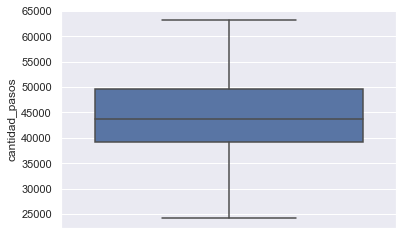

In [19]:
sns.boxplot(y=diario.cantidad_pasos)

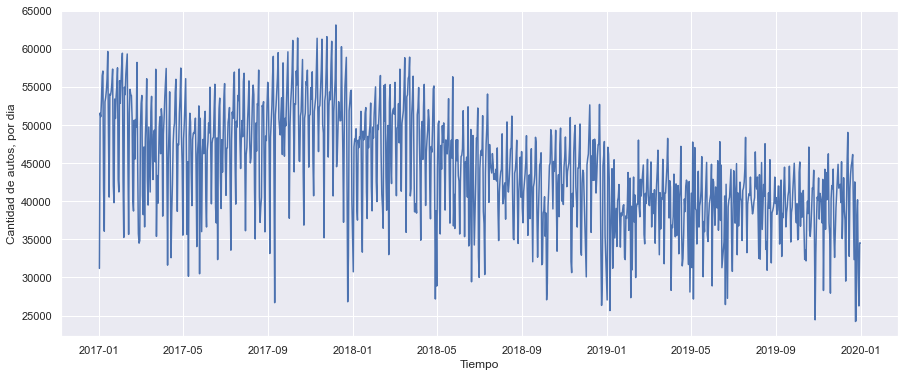

In [20]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

#### Año 2020<a name="id15"></a>

#### Voy a traer los datos reales del 2020 para una vez elegido el mejor modelo que predice el último trimesre del 2019, poder observar su performance respecto a la predicción para el año 2020

In [21]:
data_2020 = pd.read_csv('Datasets/flujo-vehicular-2020.csv', sep =',')

Estamos trabajando con la estación Illia y la forma de pago Efectivo

In [22]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion','mes','dia_fecha','observacion'], inplace = True)

data_2020.head()

,fecha,dia,hora_fin,tipo_vehiculo,sentido,cantidad_pasos
52,2020-01-01 00:00:00,Miércoles,1.0,Auto,Centro,326.0
53,2020-01-01 00:00:00,Miércoles,1.0,Auto,Provincia,319.0
134,2020-01-01 00:00:00,Miércoles,2.0,Auto,Centro,199.0
135,2020-01-01 00:00:00,Miércoles,2.0,Auto,Provincia,180.0
202,2020-01-01 00:00:00,Miércoles,3.0,Auto,Centro,114.0


In [23]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.head()

,dia,tipo_vehiculo,sentido,cantidad_pasos,fecha2
52,Miércoles,Auto,Centro,326.0,2020-01-01 01:00:00
53,Miércoles,Auto,Provincia,319.0,2020-01-01 01:00:00
134,Miércoles,Auto,Centro,199.0,2020-01-01 02:00:00
135,Miércoles,Auto,Provincia,180.0,2020-01-01 02:00:00
202,Miércoles,Auto,Centro,114.0,2020-01-01 03:00:00


In [24]:
#Corregimos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_2020.head()

,dia,tipo_vehiculo,sentido,cantidad_pasos,fecha
52,Miércoles,Auto,Centro,326.0,2020-01-01 01:00:00
53,Miércoles,Auto,Provincia,319.0,2020-01-01 01:00:00
134,Miércoles,Auto,Centro,199.0,2020-01-01 02:00:00
135,Miércoles,Auto,Provincia,180.0,2020-01-01 02:00:00
202,Miércoles,Auto,Centro,114.0,2020-01-01 03:00:00


In [25]:
#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)
data_2020

,dia,tipo_vehiculo,sentido,cantidad_pasos,fecha
0,Miércoles,Moto,Centro,7.0,2020-01-01 00:00:00
1,Miércoles,Auto,Provincia,423.0,2020-01-01 00:00:00
2,Miércoles,Auto,Centro,467.0,2020-01-01 00:00:00
3,Miércoles,Moto,Provincia,6.0,2020-01-01 00:00:00
4,Miércoles,Pesados 2 Ejes,Centro,1.0,2020-01-01 00:00:00
...,...,...,...,...,...
52369,Jueves,Auto,Provincia,222.0,2020-12-31 20:00:00
52370,Jueves,Auto,Provincia,106.0,2020-12-31 21:00:00
52371,Jueves,Moto,Centro,5.0,2020-12-31 21:00:00
52372,Jueves,Moto,Provincia,1.0,2020-12-31 21:00:00


In [26]:
#Resampleamos nuestros datos para agrupar por dia
diario_2020 = data_2020.resample('D', on = 'fecha').sum()
print(diario_2020.shape)
diario_2020.head()

(366, 1)


,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0


#### Train Test Split<a name="id16"></a>

***Implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019.***

In [27]:
diario.shape

(1095, 1)

In [28]:
diario.tail()

,cantidad_pasos
fecha,
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0
2019-12-30,34523.0
2019-12-31,34523.0


In [29]:
train = diario[diario.index < "2019-10-01"]
test = diario[diario.index >= "2019-10-01"]

In [30]:
print(train.shape)
print(test.shape)

(1003, 1)
(92, 1)


### 2) Formula una nueva pregunta, problema o desafío para explorar:  

##### Probar modelos de Machine Learning nuevos, no vistos en la carrera. 

***Subíndice***   
1. [Redes Neuronales](#id21)
2. [Arima](#id22)
3. [Sarima](#id23)
4. [Auto Arima Configurado](#id24)
5. [Prophet](#id25)    
6. [Comparación Redes Neuronales (LSTM), Auto Arima, Sarima, Auto Arima Configurado y Prophet](#id26)
7. [Aplicación modelo elegido, para predecir el año 2020](#id27)

### Redes Neuronales<a name="id21"></a>

**LSTM (Long Short-Term Memory network) es un tipo de red neuronal recurrente capaz de recordar la información pasada y, al predecir los valores futuros, tiene en cuenta esta información pasada.**

Problema común con las redes neuronales recurrentes:

    *La información del principio se va perdiendo con el tiempo

Solución: 

    *Memoria a Largo Plazo, Long Short-Term Memory Cells

#### Escalando los datos

Por lo general cuando se ejecuta una red neuronal, es necesario escalar los datos o normalizarlos.
Existen muchos enfoques para realizar esto, pero usaremos el correspondiente a dividir los datos por el valor máximo.

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()

In [33]:
scaler.fit(train)

MinMaxScaler()

In [34]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.


In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [36]:
# Definimos el generator
n_input = 28 #Vamos a utilizar 28 días y que luego prediga el siguiente
n_features = 1 #Variables que ingresamos, en este caso, la misma serie
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [37]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [38]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.14763722 0.69157083 0.67889639 0.7386397  0.82279798 0.83867439
 0.42524749 0.27790378 0.73074152 0.74581743 0.77041919 0.81095072
 0.90724978 0.62342237 0.39747045 0.75809163 0.75486298 0.76895162
 0.7977693  0.84550524 0.43778851 0.37767164 0.74069429 0.67254583
 0.74731168 0.78594872 0.85001468 0.45844118]
Predict this y: 
 [[0.41540145]]


#### Creando el Modelo

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [40]:
#Defino el modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features))) #Cantidad de neuronas, Función de activación que usaremos, y el input shape del generator
model.add(Dense(1)) #1 capa densa, porque queremos una sola predicción, Output
model.compile(optimizer='adam', loss='mse') #Optimizador: 'adam', y función de pérdida: el error cuadrado medio

In [41]:
#Resumen del modelo. Va a mostrar la complejidad del modelo, la cantidad de parámetros que va a calcular
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [42]:
#Entreno el modelo. 
#Le vamos a pasar el objeto generator que generamos. 
#Una Epoch es una carrera completa a través de los datos de entrenamiento. 
#Buscaremos que el error disminuya y se mantenga estable. En ese caso no agregaremos más epochs.
model.fit_generator(generator,epochs=50)

Epoch 1/50
975/975 [==============================] - 8s 7ms/step - loss: 0.0317
Epoch 2/50
975/975 [==============================] - 6s 7ms/step - loss: 0.0280
Epoch 3/50
975/975 [==============================] - 6s 7ms/step - loss: 0.0267
Epoch 4/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0236
Epoch 5/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0214
Epoch 6/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0203
Epoch 7/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0198
Epoch 8/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0188
Epoch 9/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0180
Epoch 10/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0177
Epoch 11/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0178
Epoch 12/50
975/975 [==============================] - 6s 6ms/step - loss: 0.0175
Epoch 13/50
975/975 [====

In [43]:
model.history.history.keys()

dict_keys(['loss'])

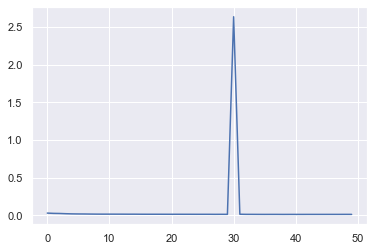

In [44]:
#Graficamos la curva del error,a medida que aumentan las epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
#plt.ylim(0.01,0.03)

#### Evaluando en los Datos de Prueba (Test)

In [45]:
#28 días de historia ---> predecir el siguiente
#Necesitaremos los últimos 28 días del conjunto de entrenamiento para predecir el 1er día en el conjunto de prueba
first_eval_batch = scaled_train[-n_input:]

In [46]:
first_eval_batch #primer batch de entrenamiento/validación

array([[0.352723  ],
       [0.43610748],
       [0.43504016],
       [0.23294287],
       [0.33014916],
       [0.45700029],
       [0.18944953],
       [0.33996851],
       [0.32531953],
       [0.43391947],
       [0.50198789],
       [0.39907143],
       [0.29292633],
       [0.3439176 ],
       [0.36403661],
       [0.40176642],
       [0.41828321],
       [0.50553673],
       [0.4047816 ],
       [0.24004056],
       [0.34349067],
       [0.36131494],
       [0.4225525 ],
       [0.46588574],
       [0.51591643],
       [0.43426635],
       [0.33882114],
       [0.30738853]])

In [47]:
#Vamos a observar las dimensiones del generator
X.shape 

(1, 28, 1)

In [48]:
#Hacemos un reshape, para que la primera validación tenga las mismas dimensiones
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [49]:
first_eval_batch.shape

(1, 28, 1)

In [50]:
#Predecimos pasandole el primer conjunto de entrenamiento/validación, para que prediga el día siguiente
model.predict(first_eval_batch)

array([[0.35986748]], dtype=float32)

In [51]:
#Observamos los valores reales de test, para comparar la primera predicción
scaled_test

array([[ 0.37406943],
       [ 0.24796542],
       [ 0.25092724],
       [ 0.48362996],
       [ 0.52031913],
       [ 0.29543453],
       [ 0.41129226],
       [ 0.32670705],
       [ 0.33220375],
       [ 0.42063132],
       [ 0.28638899],
       [ 0.17901646],
       [ 0.21282387],
       [ 0.17392   ],
       [ 0.32761427],
       [ 0.38282146],
       [ 0.33964832],
       [ 0.57248446],
       [ 0.28115911],
       [ 0.25970595],
       [ 0.29450063],
       [ 0.35515116],
       [ 0.42924994],
       [ 0.42540758],
       [ 0.49134136],
       [ 0.26216079],
       [-0.03244657],
       [ 0.19828161],
       [ 0.31966273],
       [ 0.39696347],
       [ 0.38714412],
       [ 0.46436481],
       [ 0.3203298 ],
       [ 0.41022494],
       [ 0.39586947],
       [ 0.37793847],
       [ 0.30693492],
       [ 0.45937508],
       [ 0.07033647],
       [ 0.32254449],
       [ 0.49478347],
       [ 0.28454786],
       [ 0.4832564 ],
       [ 0.3882648 ],
       [ 0.44923553],
       [ 0

#### Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.

In [52]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
test_predictions

[array([0.35986748], dtype=float32),
 array([0.39651304], dtype=float32),
 array([0.43208936], dtype=float32),
 array([0.4412747], dtype=float32),
 array([0.41141835], dtype=float32),
 array([0.36768362], dtype=float32),
 array([0.312211], dtype=float32),
 array([0.34435073], dtype=float32),
 array([0.35506058], dtype=float32),
 array([0.41920123], dtype=float32),
 array([0.45671177], dtype=float32),
 array([0.42397246], dtype=float32),
 array([0.34763408], dtype=float32),
 array([0.30422845], dtype=float32),
 array([0.33885267], dtype=float32),
 array([0.35050052], dtype=float32),
 array([0.3938309], dtype=float32),
 array([0.4436291], dtype=float32),
 array([0.4212794], dtype=float32),
 array([0.3544023], dtype=float32),
 array([0.31196013], dtype=float32),
 array([0.32915077], dtype=float32),
 array([0.3461843], dtype=float32),
 array([0.40042728], dtype=float32),
 array([0.4372068], dtype=float32),
 array([0.4350112], dtype=float32),
 array([0.35837966], dtype=float32),
 array([0.3

In [54]:
scaled_test

array([[ 0.37406943],
       [ 0.24796542],
       [ 0.25092724],
       [ 0.48362996],
       [ 0.52031913],
       [ 0.29543453],
       [ 0.41129226],
       [ 0.32670705],
       [ 0.33220375],
       [ 0.42063132],
       [ 0.28638899],
       [ 0.17901646],
       [ 0.21282387],
       [ 0.17392   ],
       [ 0.32761427],
       [ 0.38282146],
       [ 0.33964832],
       [ 0.57248446],
       [ 0.28115911],
       [ 0.25970595],
       [ 0.29450063],
       [ 0.35515116],
       [ 0.42924994],
       [ 0.42540758],
       [ 0.49134136],
       [ 0.26216079],
       [-0.03244657],
       [ 0.19828161],
       [ 0.31966273],
       [ 0.39696347],
       [ 0.38714412],
       [ 0.46436481],
       [ 0.3203298 ],
       [ 0.41022494],
       [ 0.39586947],
       [ 0.37793847],
       [ 0.30693492],
       [ 0.45937508],
       [ 0.07033647],
       [ 0.32254449],
       [ 0.49478347],
       [ 0.28454786],
       [ 0.4832564 ],
       [ 0.3882648 ],
       [ 0.44923553],
       [ 0

### Transformación inversa y Comparación

Ya que hicimos un escalado/normalización de los datos al comenzar el modelo, es que ahora para regresar los valores a las dimensiones originales, es que tenemos que hacer la transformación inversa.

In [55]:
true_predictions = scaler.inverse_transform(test_predictions)

In [56]:
true_predictions

array([[39136.75367454],
       [40510.11938125],
       [41843.41289106],
       [42187.65202743],
       [41068.72544864],
       [39429.67899904],
       [37350.73190483],
       [38555.23213628],
       [38956.60525894],
       [41360.40431091],
       [42766.18697071],
       [41539.21579525],
       [38678.28230643],
       [37051.5698016 ],
       [38349.18165484],
       [38785.7081396 ],
       [40409.6004678 ],
       [42275.88725668],
       [41438.2880958 ],
       [38931.9351356 ],
       [37341.32982686],
       [37985.58326241],
       [38623.94950944],
       [40656.81324214],
       [42035.1994217 ],
       [41952.91504437],
       [39080.99459416],
       [37118.27228421],
       [37773.02124444],
       [38335.54763657],
       [39966.65514934],
       [41400.8741248 ],
       [41519.88557863],
       [39694.90069535],
       [37563.88029617],
       [37521.55419177],
       [38101.91526923],
       [39249.0257439 ],
       [41176.04294235],
       [41285.81426895],


In [57]:
test

,cantidad_pasos
fecha,
2019-10-01,39669.0
2019-10-02,34943.0
2019-10-03,35054.0
2019-10-04,43775.0
2019-10-05,45150.0
...,...
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0


In [58]:
#Guardamos en otra columna las predicciones
test['Predictions'] = true_predictions

In [59]:
test.rename(columns={'Predictions':'RNN_LSTM'},inplace = True)
test

,cantidad_pasos,RNN_LSTM
fecha,,
2019-10-01,39669.0,39136.753675
2019-10-02,34943.0,40510.119381
2019-10-03,35054.0,41843.412891
2019-10-04,43775.0,42187.652027
2019-10-05,45150.0,41068.725449
...,...,...
2019-12-27,40182.0,37476.597784
2019-12-28,30681.0,38304.281092
2019-12-29,26259.0,38710.826586


<AxesSubplot:xlabel='fecha'>

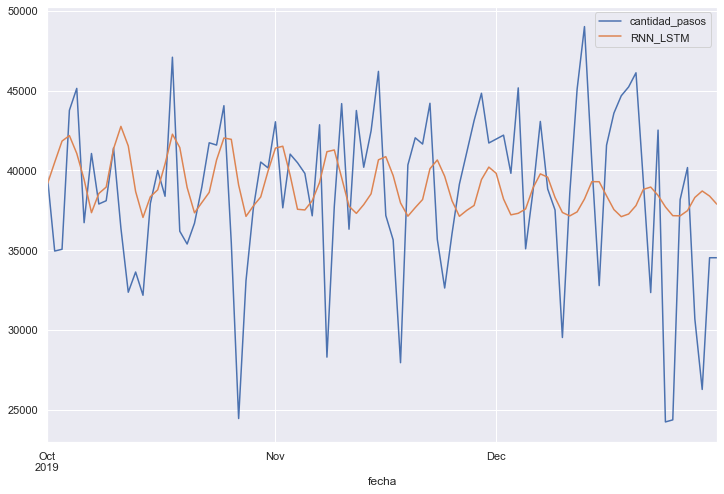

In [60]:
#Graficamos ambas curvas
test.plot(figsize=(12,8))

#### Métricas

In [61]:
from sklearn.metrics import mean_squared_error 
rmse_RNN_LSTM = np.sqrt(mean_squared_error(test.cantidad_pasos, test.RNN_LSTM ))
print('RMSE Red Neuronal LSTM :',rmse_RNN_LSTM)

RMSE Red Neuronal LSTM : 5344.131969484125


### ARIMA<a name="id22"></a>

MODELO AUTORREGRESIVO (AR): Los modelos autorregresivos predicen el valor actual de nuestra serie
temporal en función de los valores pasados.

MODELO DE MEDIAS MÓVILES (MA) :Los modelos de medias móviles predicen el valor actual de nuestra serie
temporal en función de los residuos pasados.

MODELO AUTORREGRESIVO DE MEDIAS MÓVILES (ARMA): Es la combinación de ambos modelos AR y MA, con lo cual un modelo ARMA
tendría dos órdenes (p,q), donde p es el orden de la parte autorregresiva y
q es el orden de la parte de medias móviles.

MODELO AUTORREGRESIVO INTEGRADO DE MEDIAS MÓVILES (ARIMA) :Es un modelo ARMA aplicado al resultado de integrar la serie temporal un número de veces determinado, por el orden de integración. Es decir, un modelo ARIMA de orden (p,d,q) consiste en integrar la serie original d veces, y luego ajustar un modelo ARMA(p,q) a esa serie integrada. El objetivo de la
integración es obtener una serie estacionaria, ya que los modelos ARMA funcionan peor para series no estacionarias. 

In [62]:
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from prophet import Prophet
import warnings
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

In [63]:
#Dividmos los datos en train/test
train_arima = diario[diario.index < "2019-10-01"]
test_arima = diario[diario.index >= "2019-10-01"]

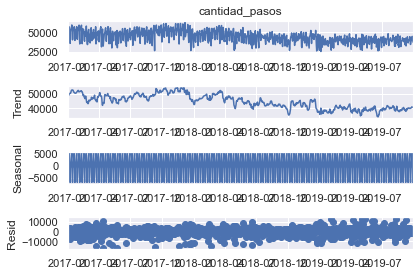

In [64]:
#Observamos los componentes de la serie
sd = seasonal_decompose(train_arima['cantidad_pasos'], model='additive')
sd.plot();

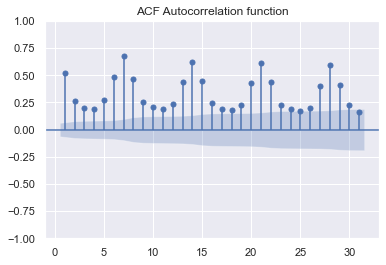

In [65]:
#La función de autocorrelación proporciona la autocorrelación para cualquier retraso que consideremos
plot_acf(train_arima['cantidad_pasos'], zero = False)
plt.title("ACF Autocorrelation function")
plt.show()

Las líneas en el gráfico representan la autocorrelación entre la serie de tiempo y una versión retrasada de sí misma. La primera línea indica laautocorrelación con retraso de 1 período de tiempo, la segunda línea representa la autocorrelación para hace dos períodos y así sucesivamente

La autocorrelación mide la similitud entre una serie temporal y una versiones anteriores de sí misma. 
Sin embargo, los coeficientes también capturanefectos de los momentos anteriores de manera indirecta. 
Por indirecta nos referimos a todos los demás canales a través de los cuales los datos del pasado afectan a los datos actuales. 

Si deseamos determinar solo la relación directa entre la serie de tiempo y su versión retrasada, necesitamos calcular
la ***autocorrelación parcial***

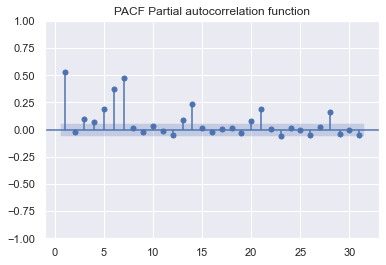

In [66]:
plot_pacf(train_arima['cantidad_pasos'], zero = False, method = ('ols'))
plt.title("PACF Partial autocorrelation function")
plt.show()

En la gráfica observamos retrasos significativos cada 7 días

La función PACF se utilizará para investigar cuántos retrasos es necesario en el ***modelo autorregresivo*** y en el ***modelo de Medias Móviles***.

#### ¿CÓMO SELECCIONAR EL MODELO MÁS APROPIADO?

Al comparar varios modelos con el mismo número total de parámetros estimados, vamos a usar los criterios de información de cada uno. Los dos criterios de información más usados son el AIC y el BIC

***AIC: Akaike Information Criteria***

***BIC: Bayesian Information Criteria***

El mejor modelo será el que tenga ***menor*** AIC o BIC.

Además se mirará el valor de la log-verosimilitud (LL: log likelihood) de ambos modelos en el resumen estadístico. El mejor modelo será el que tenga ***mayor*** LL.


#### AUTO ARIMA

Es el método automático para estimar el mejor modelo que se ajusta a la serie temporal. Por defecto tiene parámetros fijados, como por ejemplo el orden máximo que puede tomar el modelo, que luego ajustaremos.

In [67]:
model_auto = auto_arima(train_arima)

In [68]:
model_auto.summary() #Resumen del modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1003
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -9908.052
Date:                Thu, 27 Jan 2022   AIC                          19838.104
Time:                        17:07:06   BIC                          19892.112
Sample:                             0   HQIC                         19858.629
                               - 1003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0035      0.054     18.511      0.000       0.897       1.110
ar.L2         -1.5767      0.051    -31.219      0.000      -1.676      -1.478
ar.L3          1.0467      0.075     13.874      0.000       0.899       1.195
ar.L4         -1.1166      0.040    -27.755      0.000      -1.195      -1.038
ar.L5          0.1866      0.045      4.128      0.000       0.098       0.275
ma.L1         -1.7422      0.042    -41.184      0.000      -1.825      -1.659
ma.L2          2.1204      0.083     25.687      0.000       1.959       2.282
ma.L3         -1.9963      0.099    -20.222      0.000      -2.190      -1.803
ma.L4          1.5395      0.076     20.206      0.000       1.390       1.689
ma.L5         -0.8218      0.037    -22.016      0.000      -0.895      -0.749
sigma2      2.804e+07    4.5e-09   6.23e+15      0.000     2.8e+07     2.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               432.75
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.85
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+31. Standard errors may be unstable.
"""

#### Predicciones

In [69]:
len(test_arima)

92

In [70]:
pred = pd.DataFrame(model_auto.predict(n_periods = len(test_arima)), index = test_arima.index)

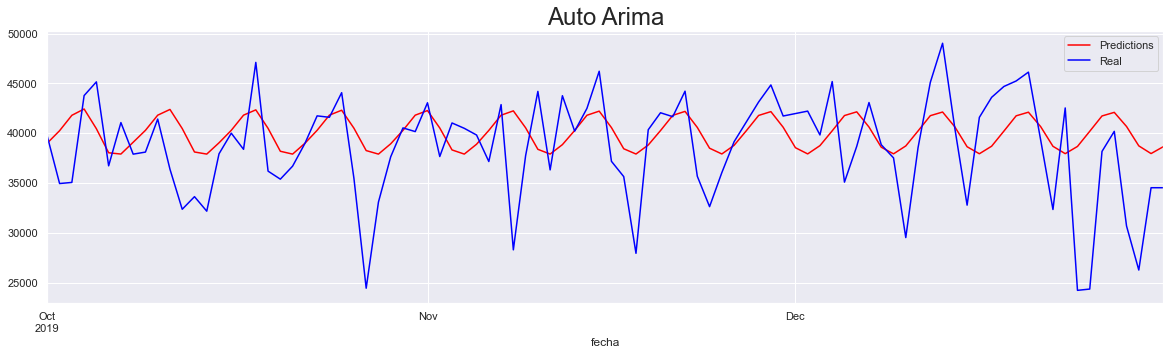

In [71]:
pred.plot(figsize = (20,5), color = "red")
test_arima['cantidad_pasos'].plot(color = "blue")
plt.title("Auto Arima", size = 24)
plt.legend(['Predictions','Real'])
plt.show()

In [72]:
test['autoarima']=pred.values

#### Comparación numérica

In [73]:
from sklearn.metrics import mean_squared_error 
rmse_autoarima = np.sqrt(mean_squared_error(test.cantidad_pasos, test['autoarima']))
print('RMSE Autoarima:',rmse_autoarima)

RMSE Autoarima: 5007.943451135212


### SARIMA<a name="id23"></a>

SARMA, SARIMA:
Vamos a recordar que la estacionalidad ocurre cuando ciertos patrones aparecen periódicamente, por ejemplo, algo que se repite cada año. Por lo tanto, en este caso, un modelo simple autorregresivo AR no describirá bien los datos. ¿Por qué? Porque sólo considera el valor del período anterior para estimar el periodo actual. ¿Entonces qué haríamos en este caso? Necesitaríamos incluir los valores registrados durante el período de hace un año.

Entonces primero necesitamos definir el orden estacional que es ese ciclo que sospechamos que se repite. Por ejemplo, si nuestros datos son diarios, y el ciclo se repite cada semana, un buen orden sería 7. Si nuestros datos son mensuales y observamos una repetición anual, un buen orden sería 12.

Tendremos una variante estacional para todos los modelos que hemos estudiado: SARMA, SARIMA. Y, por ejemplo, un SARIMA tendría orden (p,d,q)(P,D,Q,s), donde p,d,q son los órdenes no estaciones del modelo y P,D,Q son los órdenes estacionales, que se refieren a los retrasos que se añaden respecto al orden estacional s.

#### Voy a generar a continuación un modelo SARIMA indicandole los órdenes encontrados por el modelo AUTO ARIMA y agregándole el componente estacional.

#### Ciclo igual a 7 días.

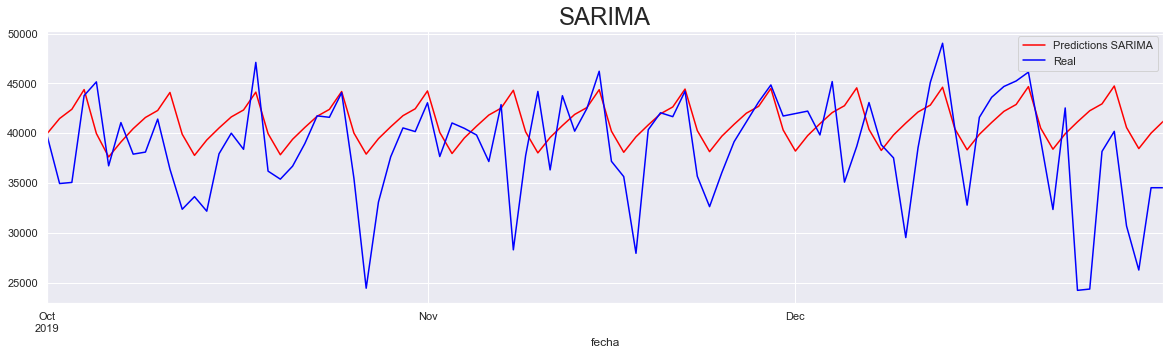

In [74]:
model_sarima = SARIMAX(train_arima, order = (5,1,4), seasonal_order = (1,1,1,7))
results_sarima = model_sarima.fit()
start_date='2019-10-01'
end_date='2019-12-31'
pred_sarima = results_sarima.predict(start = start_date, end = end_date)

pred_sarima.plot(figsize = (20,5), color = "red")
test_arima['cantidad_pasos'].plot(color = "blue")
plt.title("SARIMA", size = 24)
plt.legend(['Predictions SARIMA','Real'])
plt.show()

In [75]:
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      cantidad_pasos   No. Observations:                 1003
Model:             SARIMAX(5, 1, 4)x(1, 1, [1], 7)   Log Likelihood               -9876.855
Date:                             Thu, 27 Jan 2022   AIC                          19777.711
Time:                                     17:07:12   BIC                          19836.543
Sample:                                 01-01-2017   HQIC                         19800.077
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0314      0.770     -1.339      0.181      -2.541       0.478
ar.L2         -0.6090      0.914     -0.667      0.505      -2.400       1.182
ar.L3         -0.5133      0.491     -1.046      0.296      -1.475       0.449
ar.L4         -0.1774      0.162     -1.095      0.273      -0.495       0.140
ar.L5         -0.1328      0.092     -1.436      0.151      -0.314       0.048
ma.L1          0.4247      0.775      0.548      0.584      -1.094       1.943
ma.L2         -0.1227      0.763     -0.161      0.872      -1.618       1.372
ma.L3          0.0284      0.553      0.051      0.959      -1.056       1.113
ma.L4         -0.2608      0.420     -0.621      0.535      -1.084       0.562
ar.S.L7        0.0815      0.104      0.783      0.434      -0.122       0.285
ma.S.L7       -0.9384      0.023    -41.118      0.000      -0.983      -0.894
sigma2      3.598e+07   6.55e-08   5.49e+14      0.000     3.6e+07     3.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               623.23
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -1.18
Prob(H) (two-sided):                  0.32   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+31. Standard errors may be unstable.
"""

In [76]:
test['Sarima']=pred_sarima.values

In [77]:
rmse_sarima = np.sqrt(mean_squared_error(test.cantidad_pasos, test['Sarima']))
print('RMSE Autoarima Conf:',rmse_sarima)

RMSE Autoarima Conf: 5339.177207190362


### Configurando Auto Arima<a name="id24"></a>

Cambiaremos los parámetros prefijados por defecto: 
       
       *max_order=None (Que no tenga un límite máximo en la suma de los órdenes)
       *start_p=1 (Por defecto comienza en 2) 
       *start_q=1 (Por defecto comienza en 2)
       *max_p=14  (Máximo orden AR)
       *max_q=14  (Máximo orden MA)
       *n_jobs = -1 (cuantos modelos puede entrenar al mismo tiempo (-1 indica "Los que sean posibles")
       *alpha = 0.05 (nivel de significación)

y agregaremos el componente estacional, indicandole la magnitud del ciclo (en este caso, el ciclo se repite cada 7 días):
        
       *m=7 (Duración del ciclo estacional)


In [78]:
model_auto_conf = auto_arima(train_arima, start_p=1,start_q=1, max_p=14,max_q=14, max_order=None,start_P=1,start_Q=0,m=7,D=1, 
                             alpha = 0.05, n_jobs = -1)
model_auto_conf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1003
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -9866.650
Date:                             Thu, 27 Jan 2022   AIC                          19741.300
Time:                                     17:07:57   BIC                          19760.915
Sample:                                          0   HQIC                         19748.757
                                            - 1003                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3514      0.024     14.924      0.000       0.305       0.398
ma.L2          0.1965      0.027      7.306      0.000       0.144       0.249
ma.S.L7       -0.8739      0.017    -51.931      0.000      -0.907      -0.841
sigma2       2.33e+07   2.05e-10   1.14e+17      0.000    2.33e+07    2.33e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):               411.44
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.74
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.45e+31. Standard errors may be unstable.
"""

In [79]:
pred_auto_conf = pd.DataFrame(model_auto_conf.predict(n_periods = len(test_arima)), index = test_arima.index)

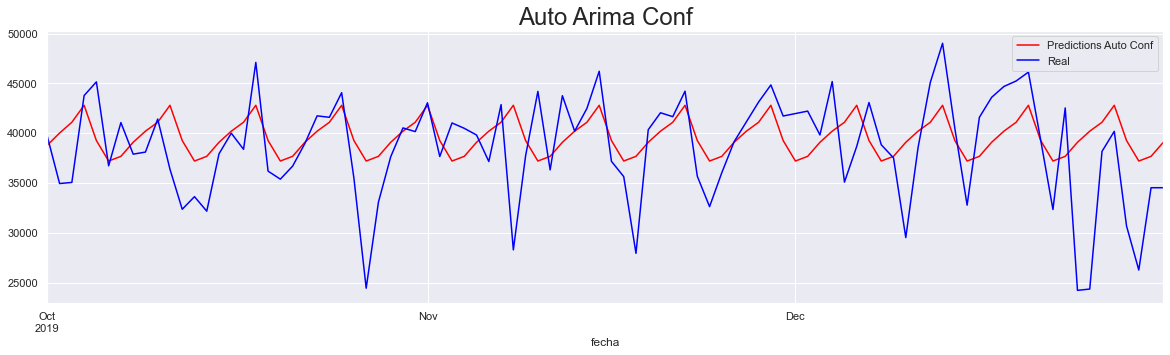

In [80]:
pred_auto_conf.plot(figsize = (20,5), color = "red")
test_arima['cantidad_pasos'].plot(color = "blue")
plt.title("Auto Arima Conf", size = 24)
plt.legend(['Predictions Auto Conf','Real'])
plt.show()

In [81]:
test['Auto_Arima_Configurado']=pred_auto_conf.values

In [82]:
test

,cantidad_pasos,RNN_LSTM,autoarima,Sarima,Auto_Arima_Configurado
fecha,,,,,
2019-10-01,39669.0,39136.753675,39007.307462,39982.315628,38795.786135
2019-10-02,34943.0,40510.119381,40248.496692,41470.097801,40014.901935
2019-10-03,35054.0,41843.412891,41792.869360,42399.763105,41094.781197
2019-10-04,43775.0,42187.652027,42426.723136,44375.520144,42797.336639
2019-10-05,45150.0,41068.725449,40445.537980,39968.005434,39259.220295
...,...,...,...,...,...
2019-12-27,40182.0,37476.597784,42088.913656,44735.010585,42797.336639
2019-12-28,30681.0,38304.281092,40671.595377,40566.382157,39259.220295
2019-12-29,26259.0,38710.826586,38724.973962,38451.434199,37202.400238


In [83]:
from sklearn.metrics import mean_squared_error 
rmse_autoarima_conf = np.sqrt(mean_squared_error(test.cantidad_pasos, test['Auto_Arima_Configurado']))
print('RMSE Autoarima Conf:',rmse_autoarima_conf)

RMSE Autoarima Conf: 4828.720211897291


### Prophet<a name="id25"></a>

Esta librería desarrollada por Facebook, busca estudiar los componentes de nuestras series temporales. Incluye dentro de sus algoritmos modelos de predicción, de detección de anomalías, análisis de estacionalidad para distintas granularidades temporales, estudios de tendencia, entre muchas otras opciones.

In [84]:
train_prophet = train.copy()

In [85]:
train_prophet

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0
...,...
2019-09-26,43110.0
2019-09-27,44985.0
2019-09-28,41925.0


In [86]:
train_prophet.reset_index(inplace=True)

In [87]:
#Prophet requiere que los datos que le pasemos, presenten rigurosamente la siguiente estructura
train_prophet.columns = ['ds','y']
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
train_prophet.head(2)

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0


In [88]:
test_prophet = test.copy()

In [89]:
test_prophet

,cantidad_pasos,RNN_LSTM,autoarima,Sarima,Auto_Arima_Configurado
fecha,,,,,
2019-10-01,39669.0,39136.753675,39007.307462,39982.315628,38795.786135
2019-10-02,34943.0,40510.119381,40248.496692,41470.097801,40014.901935
2019-10-03,35054.0,41843.412891,41792.869360,42399.763105,41094.781197
2019-10-04,43775.0,42187.652027,42426.723136,44375.520144,42797.336639
2019-10-05,45150.0,41068.725449,40445.537980,39968.005434,39259.220295
...,...,...,...,...,...
2019-12-27,40182.0,37476.597784,42088.913656,44735.010585,42797.336639
2019-12-28,30681.0,38304.281092,40671.595377,40566.382157,39259.220295
2019-12-29,26259.0,38710.826586,38724.973962,38451.434199,37202.400238


Ya que prophet cuenta con una gran funcionalidad, de permitir incluir como variable exógena los días festivos o feriados o fechas importantes para la serie. Es que a continuación voy a generar un dataframe con los días feriados de Argentina.

Este dataframe va a aportar información importante, ya que en el proyecto 3 vimos que muchos valores atípicos se generaban en días feriados.

In [90]:
Feriados = []
for i in range(2012,2022,1):
    Feriados.append(i)

years = []
for i in range(2012,2022,1):
    years.append(i)

In [91]:
import holidays
Feriados = holidays.Argentina(years=years)
Feriados = pd.DataFrame.from_dict(Feriados,orient='index').reset_index().rename(columns={'index':'ds',0:'holiday'})

In [92]:
Feriados

,ds,holiday
0,2016-01-01,Año Nuevo [New Year's Day]
1,2016-02-08,Día de Carnaval [Carnival's Day]
2,2016-02-09,Día de Carnaval [Carnival's Day]
3,2016-03-24,Semana Santa (Jueves Santo) [Holy day (Holy T...
4,2016-03-25,Semana Santa (Viernes Santo) [Holy day (Holy ...
...,...,...
172,2015-08-17,Día Pase a la Inmortalidad del General D. José...
173,2015-10-12,Día del Respeto a la Diversidad Cultural [Resp...
174,2015-11-20,Día Nacional de la Soberanía [National Soverei...
175,2015-12-08,La Inmaculada Concepción [Immaculate Conception]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


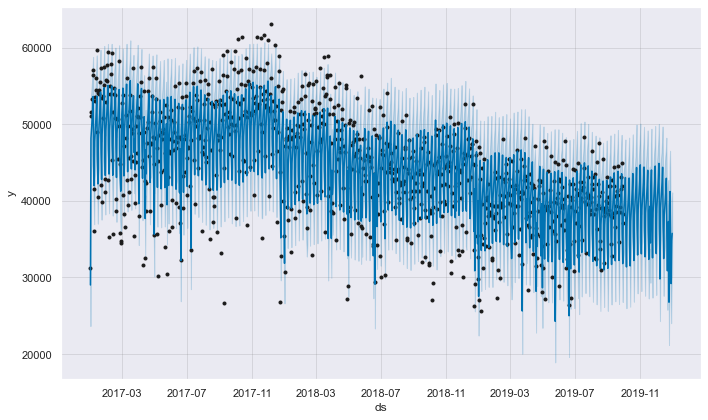

In [93]:
#Creo el modelo 
#Definiendo que debe estudiar una estacionalidad semanal y anual 
#Además indico el ingreso del dataframe con los días feriados
m = Prophet(weekly_seasonality=True, yearly_seasonality=True,seasonality_prior_scale = 0.01,
                changepoint_prior_scale=0.01,holidays=Feriados)

#Entreno el modelo
m.fit(train_prophet)

#Predecimos
future = m.make_future_dataframe(92, freq='D') # MS: primer día del mes https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
forecast = m.predict(future)

#Graficamos
fig = m.plot(forecast)

In [94]:
# Guardo las predicciones
pred_prophet = pd.DataFrame(forecast.yhat[-92:].values, index = forecast[-92:].ds.values)
pred_prophet.head(2)

,0
2019-10-01,38594.288097
2019-10-02,39807.388572


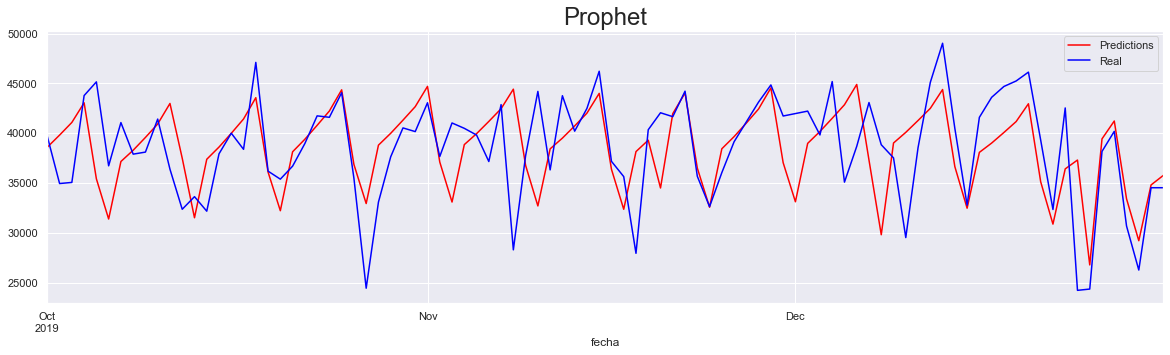

In [95]:
#Grafico las predicciones vs el test
pred_prophet.plot(figsize = (20,5), color = "red")
test_prophet['cantidad_pasos'].plot(color = "blue")
plt.title("Prophet", size = 24)
plt.legend(['Predictions','Real'])
plt.show()

In [96]:
#predictions=pd.DataFrame(pred_prophet.values,columns=['Prophet'],  index = test_prophet.index)

In [97]:
test['Prophet']=pred_prophet.values

In [98]:
from sklearn.metrics import mean_squared_error 
rmse_Prophet = np.sqrt(mean_squared_error(test.cantidad_pasos, test['Prophet']))
print('RMSE Prophet:',rmse_Prophet)

RMSE Prophet: 4646.452699990581


In [99]:
test

,cantidad_pasos,RNN_LSTM,autoarima,Sarima,Auto_Arima_Configurado,Prophet
fecha,,,,,,
2019-10-01,39669.0,39136.753675,39007.307462,39982.315628,38795.786135,38594.288097
2019-10-02,34943.0,40510.119381,40248.496692,41470.097801,40014.901935,39807.388572
2019-10-03,35054.0,41843.412891,41792.869360,42399.763105,41094.781197,41077.577716
2019-10-04,43775.0,42187.652027,42426.723136,44375.520144,42797.336639,43047.652244
2019-10-05,45150.0,41068.725449,40445.537980,39968.005434,39259.220295,35415.028518
...,...,...,...,...,...,...
2019-12-27,40182.0,37476.597784,42088.913656,44735.010585,42797.336639,41220.855484
2019-12-28,30681.0,38304.281092,40671.595377,40566.382157,39259.220295,33411.604284
2019-12-29,26259.0,38710.826586,38724.973962,38451.434199,37202.400238,29202.376154


### Comparación Redes Neuronales (LSTM), Auto Arima, Sarima, Auto Arima Configurado y Prophet<a name="id26"></a>

In [100]:
test

,cantidad_pasos,RNN_LSTM,autoarima,Sarima,Auto_Arima_Configurado,Prophet
fecha,,,,,,
2019-10-01,39669.0,39136.753675,39007.307462,39982.315628,38795.786135,38594.288097
2019-10-02,34943.0,40510.119381,40248.496692,41470.097801,40014.901935,39807.388572
2019-10-03,35054.0,41843.412891,41792.869360,42399.763105,41094.781197,41077.577716
2019-10-04,43775.0,42187.652027,42426.723136,44375.520144,42797.336639,43047.652244
2019-10-05,45150.0,41068.725449,40445.537980,39968.005434,39259.220295,35415.028518
...,...,...,...,...,...,...
2019-12-27,40182.0,37476.597784,42088.913656,44735.010585,42797.336639,41220.855484
2019-12-28,30681.0,38304.281092,40671.595377,40566.382157,39259.220295,33411.604284
2019-12-29,26259.0,38710.826586,38724.973962,38451.434199,37202.400238,29202.376154


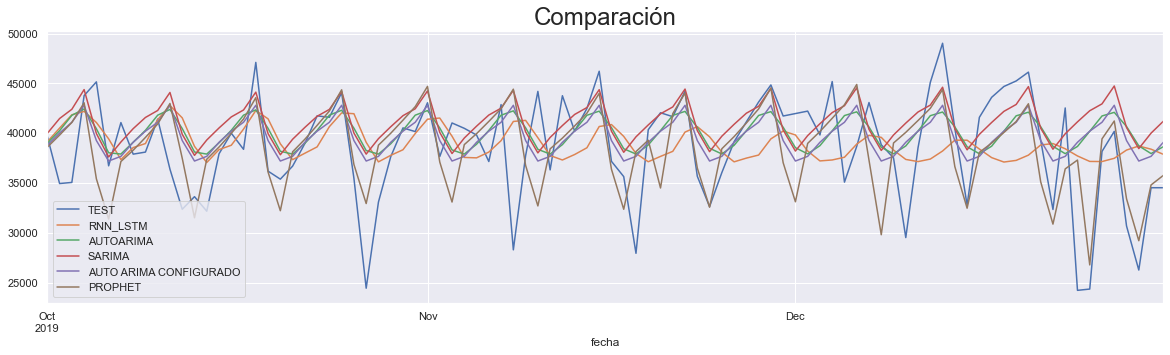

In [101]:
test.plot(figsize = (20,5)) 
plt.title("Comparación", size = 24)
plt.legend(['TEST', 'RNN_LSTM','AUTOARIMA','SARIMA','AUTO ARIMA CONFIGURADO','PROPHET'])
#plt.xlim('2019-12-01','2019-12-31')
plt.show()

##### Comparación numérica

In [102]:
print('RMSE RNN_LSTM:               ',int(rmse_RNN_LSTM))
print('RMSE Autoarima:              ',int(rmse_autoarima))
print('RMSE Sarima:                 ',int(rmse_sarima))
print('RMSE Auto Arima Configurado: ',int(rmse_autoarima_conf))
print('RMSE Prophet:                ',int(rmse_Prophet))

RMSE RNN_LSTM:                5344
RMSE Autoarima:               5007
RMSE Sarima:                  5339
RMSE Auto Arima Configurado:  4828
RMSE Prophet:                 4646


### Conclusiones

Al observar el gráfico, encuentro un rendimiento muy parejo en todos los modelos, pero con una excepción que es "PROPHET". El modelo de PROPHET se distingue interpretando mejor ciertos saltos atípicos y no constantes de la serie, y logra capturar mejor la tendencia de disminución al final del mes de diciembre.

La comparación númerica de la métrica correspondiente al error elegida (Raíz del error Cuadrático Medio), me confirma la observación gráfica.

El modelo prophet es quien tiene el menor valor para el error cuadrado medio, y por tal razón es el modelo que elegí para aplicar en el año 2020.

### Aplicación modelo elegido, para predecir el año 2020<a name="id27"></a>

#### Para predecir el año 2020, voy a alimentar el modelo elegido con los datos hasta el 31/12/2019

In [103]:
diario.tail()

,cantidad_pasos
fecha,
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0
2019-12-30,34523.0
2019-12-31,34523.0


In [104]:
train_2020 = diario
train_2020.reset_index(inplace=True)
#Prophet requiere que los datos que le pasemos, presenten rigurosamente la siguiente estructura
train_2020.columns = ['ds','y']
train_2020['ds'] = pd.to_datetime(train_2020['ds'])
train_2020.head(2)

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0


In [105]:
train_2020.tail()

,ds,y
1090,2019-12-27,40182.0
1091,2019-12-28,30681.0
1092,2019-12-29,26259.0
1093,2019-12-30,34523.0
1094,2019-12-31,34523.0


El conjunto de test, van a ser los datos reales del año 2020, pero con una salvedad ya mencionada en el proyecto 3:

En la curva real notamos un cambio abrupto en su comportamiento a partir del mes de marzo 2020 (claramente relacionado con el incio de las medidas de “aislamiento social, preventivo y obligatorio” con el fin de prevenir la circulación y el contagio del virus COVID-19, dispuesto a partir de las 00:00 horas del día 20 de marzo de 2020.*

En este contexto, vamos a evaluar los resultados de la predicción hasta el día 19/03/2020 inclusive, ya que luego de esta fecha hay un cambio sustancial y constante en el comportamiento de la serie debido a factores externos nuevos que el modelo no puede aprenderlos con los datos históricos.

In [106]:
test_2020 = diario_2020[diario_2020.index<'2020-03-20']
test_2020

,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0
...,...
2020-03-15,18390.0
2020-03-16,31168.0
2020-03-17,26407.0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


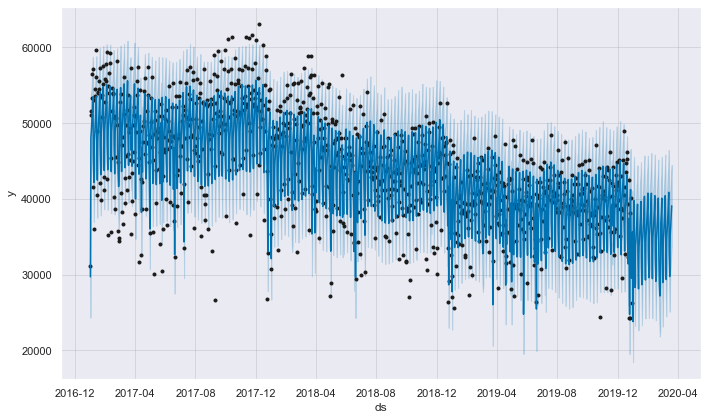

In [107]:
#Creo el modelo 
#Definiendo que debe estudiar una estacionalidad semanal y anual 
#Además indico el ingreso del dataframe con los días feriados
m = Prophet(weekly_seasonality=True, yearly_seasonality=True,seasonality_prior_scale = 0.01,
                changepoint_prior_scale=0.01,holidays=Feriados)

#Entreno el modelo
m.fit(train_2020)

#Predecimos
future = m.make_future_dataframe(79, freq='D') # MS: primer día del mes https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
forecast = m.predict(future)

#Graficamos
fig = m.plot(forecast)

In [108]:
# Guardo las predicciones
pred_prophet_2020 = pd.DataFrame(forecast.yhat[-79:].values, index = forecast[-79:].ds.values)
pred_prophet_2020.head(2)

,0
2020-01-01,23806.810981
2020-01-02,37945.479286


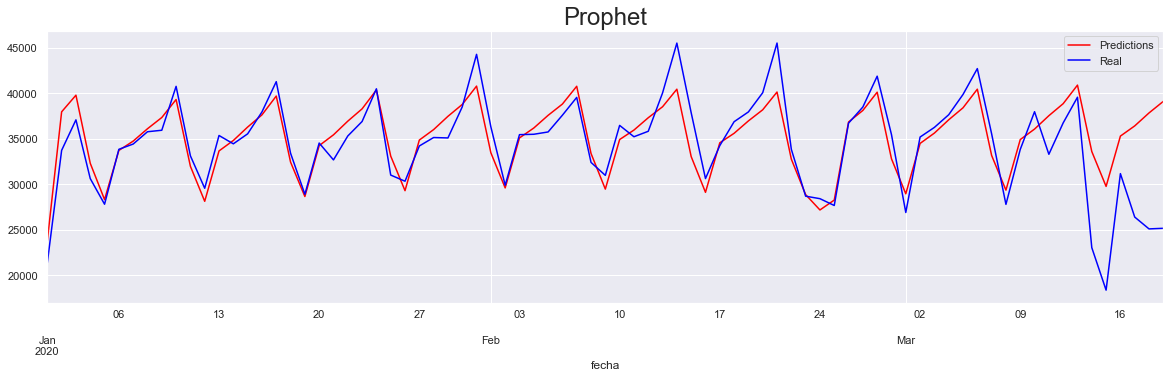

In [109]:
#Grafico las predicciones vs el test
pred_prophet_2020.plot(figsize = (20,5), color = "red")
test_2020['cantidad_pasos'].plot(color = "blue")
plt.title("Prophet", size = 24)
plt.legend(['Predictions','Real'])
plt.show()

In [110]:
test_2020['Prophet']=pred_prophet_2020.values

In [111]:
test_2020

,cantidad_pasos,Prophet
fecha,,
2020-01-01,21395.0,23806.810981
2020-01-02,33722.0,37945.479286
2020-01-03,37067.0,39769.641515
2020-01-04,30627.0,32303.313190
2020-01-05,27812.0,28320.966160
...,...,...
2020-03-15,18390.0,29766.473923
2020-03-16,31168.0,35285.045994
2020-03-17,26407.0,36401.467936


In [112]:
from sklearn.metrics import mean_squared_error 
rmse_Prophet_2020 = np.sqrt(mean_squared_error(test_2020.cantidad_pasos, test_2020['Prophet']))
print('RMSE Prophet Año 2020:',int(rmse_Prophet_2020))

RMSE Prophet Año 2020: 3509


### Conclusiones Predicción Año 2020

Gráficamente observo una gran performance del modelo, interpretando muy bien el comportamiento de la serie real, entendiendo muy bien la estacionalidad latente y prediciendo correctamente los picos (aunque un poco por debajo). En el mismo sentido y reforzando lo explicado, la predicción en su conjunto es todavía mejor hasta los comienzos del mes de marzo, ya que a partir de esta época se empiezan a visualizar los efectos de la pandemia en el país, y el modelo no cuenta con información del pasado que le permita predecirlo. 

Númericamente la métrica elegida para comparar los modelos nos arroja un valor consideramblemente inferior a los arrojados respecto al último trinestre de 2019, y sustancialmente menor al valor correspondiente al modelo estudiado en el proyecto número 3 para predecir a través de multi-step los valores del año 2020 (hasta 19/03/2020).

RMSE Prophet Año 2020 3.509 vs 7.096 Multi Step prediction (Proyecto 3) - Sustancial Mejora del 50,51%

### 3) Objetivo: 

##### El objetivo es poder aplicar los modelos mencionados con sus características particulares y lograr visalizar una comparación de los resultados que arrojan los mismos, e identificar cuál es el que mejor se ajusta al problema de referencia.

Respecto al objetivo planteado al comienzo de este proyecto, me siento muy conforme y satisfecho con el proceso, ya que apliqué todos los modelos que he estudiado que se aplican en problemas de predicción de series temporales. He podido incluir características particulares de cada uno, y tener una visión integral al comparar los mismos.

Me llevó una grata sorpresa con los resultados alcanzados, ya que gráficamente observo que el modelo pudo generalizar los datos de entrenamiento y lograr una predicción bastante ajustada a la realidad; 

y confirmándose con la sustancial mejora en la métrica de comparación elegida.